# Making Loan Granting Decisions

In this project, we have a loan dataset from a bank. The data contain all the loans asked to the bank, whether the bank decided to grant it, whether the borrower managed to repay it, and the information about the borrower at the moment he/she is asking for the loan. The goal is to build a model to predict whether a customer will repay, which can be used to decide whether to grant loans to future customers.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from scipy.stats import ks_2samp, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from treeinterpreter import treeinterpreter as ti
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')

## Load and Examine the Data

In [2]:
df_loan = pd.read_csv('data/loan_table.csv')
df_borrower = pd.read_csv('data/borrower_table.csv')

# inspect the size of the data
df_loan.shape, df_borrower.shape

((101100, 5), (101100, 12))

In [3]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
loan_id         101100 non-null int64
loan_purpose    101100 non-null object
date            101100 non-null object
loan_granted    101100 non-null int64
loan_repaid     47654 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB


In [4]:
df_borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
loan_id                                            101100 non-null int64
is_first_loan                                      101100 non-null int64
fully_repaid_previous_loans                        46153 non-null float64
currently_repaying_other_loans                     46153 non-null float64
total_credit_card_limit                            101100 non-null int64
avg_percentage_credit_card_limit_used_last_year    94128 non-null float64
saving_amount                                      101100 non-null int64
checking_amount                                    101100 non-null int64
is_employed                                        101100 non-null int64
yearly_salary                                      101100 non-null int64
age                                                101100 non-null int64
dependent_number                                   101100 non-null int64
dtypes: fl

In [5]:
df_loan.head(10)

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0
5,77085,other,2012-08-31,0,NaN
6,780070,business,2012-03-14,1,1.0
7,303138,emergency_funds,2012-08-31,1,0.0
8,91475,investment,2012-05-25,1,1.0
9,422392,business,2012-10-25,0,NaN


In [6]:
df_borrower.head(10)

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1
5,423171,1,NaN,NaN,6100,0.53,6163,5298,1,29500,24,1
6,568977,1,NaN,NaN,600,0.89,305,1456,0,0,50,2
7,200139,1,NaN,NaN,4000,0.57,602,2757,1,31700,36,8
8,991294,0,1.0,0.0,7000,0.52,2575,2917,1,58900,33,3
9,875332,0,1.0,0.0,4300,0.83,722,892,1,5400,32,7


## Data Cleaning

In [7]:
# Merge the two data frames using "loan_id"
df = pd.merge(left=df_loan, right=df_borrower, how='left', on='loan_id')

# Drop "loan_id" and "date", which are not useful for modeling
df = df.drop(['loan_id','date'], axis=1)

# Rename some columns whose names are too long 
rename = {
    'fully_repaid_previous_loans': 'previous_repaid', 
    'currently_repaying_other_loans': 'repaying',
    'total_credit_card_limit': 'credit_limit', 
    'avg_percentage_credit_card_limit_used_last_year': 'limit_used'
}
df = df.rename(columns=rename)

In [8]:
# Check the amount of NANs in each column
df.isnull().sum()

loan_purpose            0
loan_granted            0
loan_repaid         53446
is_first_loan           0
previous_repaid     54947
repaying            54947
credit_limit            0
limit_used           6972
saving_amount           0
checking_amount         0
is_employed             0
yearly_salary           0
age                     0
dependent_number        0
dtype: int64

There are 53446 NANs in ``loan_repaid``, which should be due to the fact that those customers were not granted the loan in the first place. We can check whether the number of granted loans is also 53446.

In [9]:
# Yes, it is also 53446
sum(df.loan_granted == 0)

53446

There are 54947 NANs in both ``previous_repaid`` and ``repaying``, which should be due to the fact that those customers never had a loan in the past. We can check whether there are 54947 ones in ``is_first_loan`` 

In [10]:
# Yes, it is also 54947
sum(df.is_first_loan)

54947

In [11]:
# fill the NANs in "previous_repaid" and "repaying" and make both features 
# have three categories, "NA", "YES", "NO"
df.previous_repaid.fillna(-1, inplace=True)
df.repaying.fillna(-1, inplace=True)
df.previous_repaid = df.previous_repaid.replace({0: 'No', 1: 'Yes', -1: 'NA'})
df.repaying = df.repaying.replace({0: 'No', 1: 'Yes', -1: 'NA'})

Lastly, there are 6972 NANs in ``limit_used``, which should be due to the fact that those customers have no credit card limit at all. We can check whether there are 6972 zeros in ``credit_limit`` 

In [12]:
# Yes, it is also 6972
sum(df.credit_limit == 0)

6972

In [13]:
# We can just fill these NANs using zeros
df.limit_used.fillna(0, inplace=True)

The data have the total saving account balance and total checking account balance separately. However, what matters is the total balance, as some people prefer to put most of their money in the checking accounts while some others do not. So here I create a new column ``savings``, which equals the total balance. And then ``saving_amount`` and ``checking_amount`` can be dropped.

In [14]:
df[['saving_amount', 'checking_amount']].head(10)

,saving_amount,checking_amount
0,1491,6285
1,141,5793
2,660,3232
3,3345,2764
4,1050,3695
5,1028,3269
6,4206,4368
7,886,1597
8,1837,3795
9,134,1408


In [15]:
df['savings'] = df.saving_amount + df.checking_amount
df = df.drop(['saving_amount', 'checking_amount'], axis=1)

## Exploratory Data Analysis and Visualization

### 1. Statistical Overview

In [16]:
total = sum(df.loan_granted == 1)
df.loan_repaid.value_counts() / total

1.0    0.644353
0.0    0.355647
Name: loan_repaid, dtype: float64

 About 64% of the borrowers did repay

We can use the `describe` method to inspect some statistics of each column.

In [17]:
df.describe()

,loan_granted,loan_repaid,is_first_loan,credit_limit,limit_used,is_employed,yearly_salary,age,dependent_number,savings
count,101100.000000,47654.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000
mean,0.471355,0.644353,0.543492,4112.743818,0.674202,0.658675,21020.727992,41.491632,3.864748,4976.768437
std,0.499181,0.478714,0.498107,2129.121462,0.256994,0.474157,18937.581415,12.825570,2.635491,2804.507542
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,17.000000
25%,0.000000,0.000000,0.000000,2700.000000,0.560000,0.000000,0.000000,32.000000,2.000000,2884.000000
50%,0.000000,1.000000,1.000000,4100.000000,0.710000,1.000000,21500.000000,41.000000,3.000000,4124.000000
75%,1.000000,1.000000,1.000000,5500.000000,0.850000,1.000000,35300.000000,50.000000,6.000000,6737.000000
max,1.000000,1.000000,1.000000,13500.000000,1.090000,1.000000,97200.000000,79.000000,8.000000,20558.000000


In [18]:
df.describe(include=['O'])

,loan_purpose,previous_repaid,repaying
count,101100,101100,101100
unique,5,3,3
top,home,NA,NA
freq,24314,54947,54947


Let's check the difference in numbers between the borrowers who repaid and who didn’t.

In [19]:
# Numerical features: Didn't repay v.s. Repaid (mean) 
df.groupby('loan_repaid').mean().drop(['loan_granted'], axis=1)

,is_first_loan,credit_limit,limit_used,is_employed,yearly_salary,age,dependent_number,savings
loan_repaid,,,,,,,,
0.0,0.532570,3459.352136,0.718196,0.791952,19893.114232,41.508320,4.233656,3095.128688
1.0,0.545919,5117.599166,0.669510,0.974891,34408.258972,41.533674,3.486843,6860.763857


In [20]:
# Categorical features: Didn't repay v.s. Repaid (mode) 
df.groupby('loan_repaid').agg(lambda x: x.value_counts().index[0])[['loan_purpose','previous_repaid','repaying']]

,loan_purpose,previous_repaid,repaying
loan_repaid,,,
0.0,emergency_funds,NA,NA
1.0,business,NA,NA


Just based on visual inspections, we can conclude that:
- Whether or not a person had previously asked for a loan does not make a big differnce, as the mean values of ``is_first_loan`` are similar (~54%).
- Age probably doesn't matter,  as the mean values of ``age`` are almost the same (~41.5).
- For the other numerical features, we do see differences between the two groups. 
- The most common loan purpose of the people who eventually didn't repay is ``emergency_funds``, while for the people who did repay it is ``business``.

To statistically determine whether these features are relevant, we will use hypothesis described below.

### 2. Hypothesis Testing

Hypothesis tests can be used to test whether two samples are drawn from the same distribution. If the test statistic is small or the p-value is high, we cannot reject the null hypothesis that the distributions of the two samples are the same. A typical choice for the threshold of the p-value is 0.05, which corresponds to a 95% confidence level. 
<br>

Here we can group the borrowers by whether they repaid, and then use hypothesis tests to compare the two distributions of each feature. For numerical variables, ``credit_limit``, ``limit_used``, ``yearly_salary``, ``age``, ``dependent_number`` and ``savings``, we can use [Kolmogorov–Smirnov (K-S) tests](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). For ``is_first_loan`` and ``is_employed``, the values are binary (0 or 1), so we can use [two-sample proportion Z tests](https://onlinecourses.science.psu.edu/stat414/node/268/). Lastly, for categorical vaiables, ``loan_purpose``, ``previous_repaid`` and ``repaying``, we can use [chi-squared tests](https://newonlinecourses.science.psu.edu/statprogram/node/158/).

In [21]:
def run_test(feature):
    """ run either a K-S test, a Z test, or a chi-squred test """
    
    # split the borrowers into two groups based on whether they repaid
    group1 = df.loc[df.loan_repaid == 0, feature]
    group2 = df.loc[df.loan_repaid == 1, feature]

    # if the feature is categorical, do a chi-squred test
    if df[feature].dtype.name == 'object': 
        group1 = group1.value_counts().sort_index().tolist()
        group2 = group2.value_counts().sort_index().tolist()
        chi2, p_value, _, _ = chi2_contingency([group1, group2])
        print('Chi-Sqaured test for ' + feature + ':')
        print('test statistic = {}; p-value = {}\n'.format(chi2, p_value))
    # if the feature is numerical and is binary, do a Z test 
    elif len(df[feature].unique()) == 2:
        n1, p1 = len(group1), group1.sum()
        n2, p2 = len(group2), group2.sum()
        z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
        print('Z test for ' + feature + ':')
        print('z-score = {}; p-value = {}\n'.format(z_score, p_value))
    # if the feature is numerical and is not binary, do a K-S test
    else:
        ks, p_value = ks_2samp(group1, group2)
        print('K-S test for ' + feature + ':')
        print('test statistic = {}; p-value = {}\n'.format(ks, p_value))

In [22]:
for feature in df.columns:
    if feature not in ['loan_repaid', 'loan_granted']: run_test(feature)

Chi-Sqaured test for loan_purpose:
test statistic = 1618.176084357717; p-value = 0.0

Z test for is_first_loan:
z-score = -2.7995107289405037; p-value = 0.005118011571313927

Chi-Sqaured test for previous_repaid:
test statistic = 40.79312315752653; p-value = 1.3863914026329079e-09

Chi-Sqaured test for repaying:
test statistic = 5438.768331951727; p-value = 0.0

K-S test for credit_limit:
test statistic = 0.35322588036422875; p-value = 0.0

K-S test for limit_used:
test statistic = 0.15785510619177262; p-value = 2.472612843194514e-237

Z test for is_employed:
z-score = -66.74437283169472; p-value = 0.0

K-S test for yearly_salary:
test statistic = 0.37714850430190094; p-value = 0.0

K-S test for age:
test statistic = 0.005253947381103519; p-value = 0.9231381410855173

K-S test for dependent_number:
test statistic = 0.12093414392822227; p-value = 1.7968807689326007e-139

K-S test for savings:
test statistic = 0.7061041470431791; p-value = 0.0



We see that the p-value for ``age`` is over 90%, so we cannot reject the null hypothesis. For the others, p-values are all extremely low, showing that the two samples are not drawn from the same distribution.

### 3. Distribution Plots

In addition to doing hypothesis testing, we can also visualize the distributions of the two classes. For numerical features (except for ``dependent_number``, which only has a few discrete values), I will use kernel density plots. For binary/categorical features and ``dependent_number``, I will use bar plots. Notice that in all of these plots, the scale is normalized to the total counts of each of the two classes.

In [23]:
def DensityPlot(feature):
    fig = plt.figure(figsize=(8,4))
    sns.kdeplot(df.loc[df.loan_repaid == 0, feature], color='r', shade=True, label="didn't repay")
    sns.kdeplot(df.loc[df.loan_repaid == 1, feature], color='b', shade=True, label="repaid",)
    plt.xlabel(feature)
    plt.ylabel('kernel density')
    plt.show()

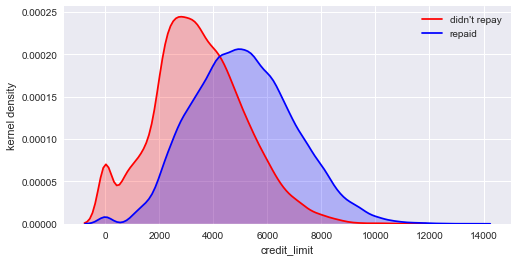

In [24]:
DensityPlot('credit_limit')

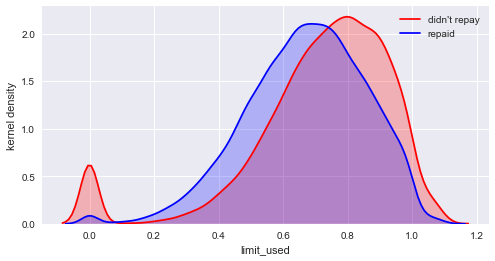

In [25]:
DensityPlot('limit_used')

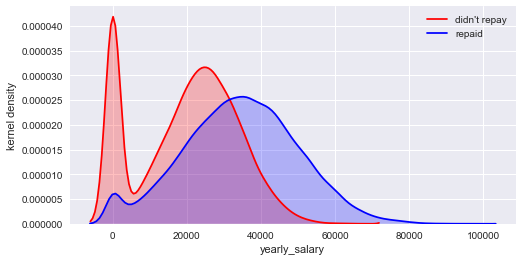

In [26]:
DensityPlot('yearly_salary')

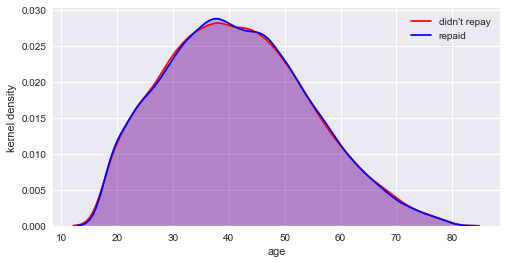

In [27]:
DensityPlot('age')

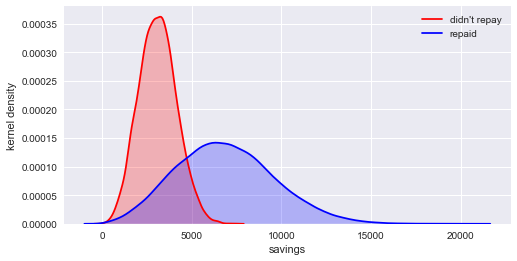

In [28]:
DensityPlot('savings')

We can see that the two distributions of ``age`` are almost identical.

In [29]:
def BarPlot(feature):
    counts = (
        df.groupby('loan_repaid')[feature]
        .value_counts(normalize=True)
        .rename('fraction')
        .reset_index()
    )
    fig = plt.figure()
    sns.barplot(x=feature, y='fraction', hue='loan_repaid', data=counts)
    plt.ylabel('fraction')
    plt.show()

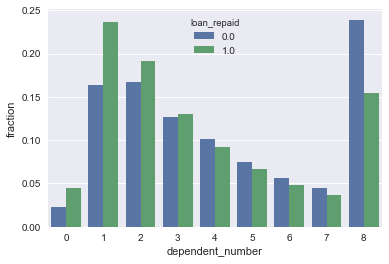

In [30]:
BarPlot('dependent_number')

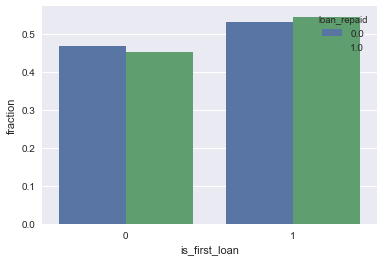

In [31]:
BarPlot('is_first_loan')

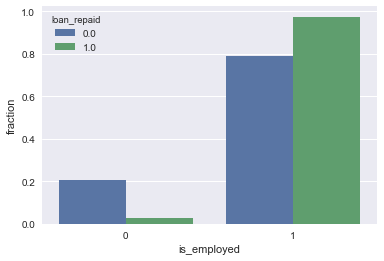

In [32]:
BarPlot('is_employed')

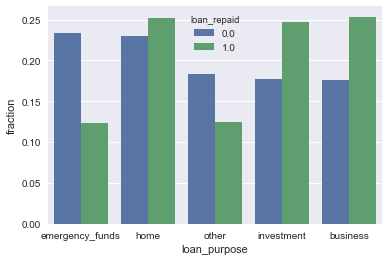

In [33]:
BarPlot('loan_purpose')

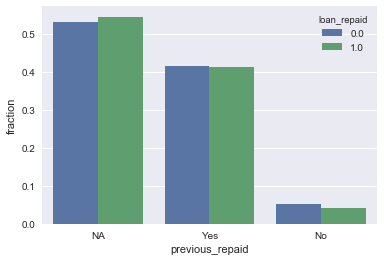

In [34]:
BarPlot('previous_repaid')

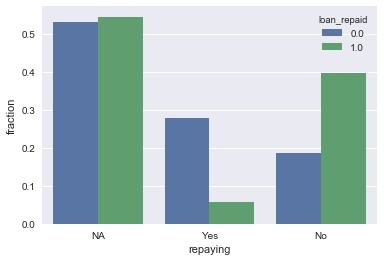

In [35]:
BarPlot('repaying')

We can see that except for ``is_first_loan`` and ``previous_repaid``, the distributions of the borrowers who did repay and who didn't repay are significantly different.

### 4. Correlation Matrix & Heatmap
Finally let's see the correlations between different numerical features.

In [36]:
corr = df.drop(['loan_granted'], axis=1).corr()
corr

,loan_repaid,is_first_loan,credit_limit,limit_used,is_employed,yearly_salary,age,dependent_number,savings
loan_repaid,1.000000,0.012824,0.401911,-0.116388,0.305749,0.426648,0.000947,-0.136384,0.621702
is_first_loan,0.012824,1.000000,0.000679,-0.002585,-0.000971,-0.001674,-0.002353,0.000887,0.006550
credit_limit,0.401911,0.000679,1.000000,0.318143,0.195274,0.222497,-0.004052,-0.058650,0.292580
limit_used,-0.116388,-0.002585,0.318143,1.000000,-0.009516,-0.011848,-0.002836,0.005154,-0.009701
is_employed,0.305749,-0.000971,0.195274,-0.009516,1.000000,0.799051,0.005059,-0.060847,0.302263
yearly_salary,0.426648,-0.001674,0.222497,-0.011848,0.799051,1.000000,0.005412,-0.073218,0.350416
age,0.000947,-0.002353,-0.004052,-0.002836,0.005059,0.005412,1.000000,0.000862,-0.002399
dependent_number,-0.136384,0.000887,-0.058650,0.005154,-0.060847,-0.073218,0.000862,1.000000,-0.097528
savings,0.621702,0.006550,0.292580,-0.009701,0.302263,0.350416,-0.002399,-0.097528,1.000000


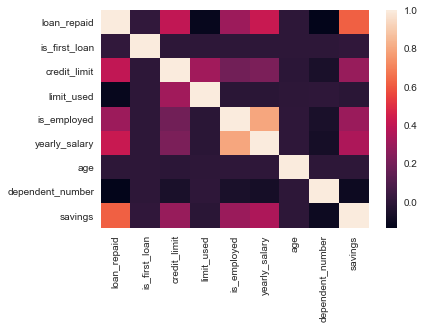

In [37]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

- The features that correlate with ``loan_repaid`` most are ``savings``, ``yearly_salary``, ``credit_limit``, and ``is_employed``.
- ``age`` and ``is_first_loan`` do not correlate with other features.
- ``yearly_salary`` and ``is_employed`` highly correlate with each other. Keeping ``yearly_salary`` is probably enough.

## Data Transformation and Train/Test Split

First, we have to transform the categories in categorical features to numerical values. I will generate two new data frames. One will be based on one-hot encoding and another will be based on label encoding. The label-encoded version will be fed to a Random Forest since one-hot encoding is not needed for tree-based models.

In [38]:
# Perform one-hot encoding
df_onehot = pd.get_dummies(df, columns=['loan_purpose','previous_repaid','repaying'])

# Drop one dummy variable for each of the three features to avoid dummy variable trap
df_onehot = df_onehot.drop(['loan_purpose_other','previous_repaid_NA','repaying_NA'], axis=1)

We will drop ``is_first_loan`` and ``age`` here since they are irrelevant. Besides, the information of ``is_first_loan`` is in ``previous_repaid`` and ``repaying`` already. We can also drop ``is_employed`` because its information is already included in ``yearly_salary`` (as we saw in the Heatmap). In fact, I had tried using the model with ``is_employed`` and without it, and the two performances are the same.

In [39]:
df_onehot = df_onehot.drop(['is_first_loan', 'age', 'is_employed'], axis=1)

Now I will generate the label-encoded version and also drop `is_first_loan`, `age`, and `is_employed`.

In [40]:
le = LabelEncoder()
df_label = df.copy()

for x in df_label.columns:    
    if df_label[x].dtype.name == 'object':
        df_label.loc[:, x] = le.fit_transform(df_label.loc[:, x])

df_label = df_label.drop(['is_first_loan', 'age', 'is_employed'], axis=1)

Now we have to split the data into three. First, the customers who were not granted loans have to be taken out because we don't know whetehr they would have repaid. Thus, they cannot be used for modeling. Secondly, I will split the remaining data into a training set and a test set, using a 70/30 split. 

In [41]:
# Those people that were not granted loans
X_declined_onehot = df_onehot[df.loan_granted == 0].reset_index(drop=True).drop(['loan_granted','loan_repaid'], axis=1)
X_declined_label = df_label[df.loan_granted == 0].reset_index(drop=True).drop(['loan_granted','loan_repaid'], axis=1)

# Those that were granted loans
X_onehot = df_onehot[df.loan_granted == 1].reset_index(drop=True).drop(['loan_granted','loan_repaid'], axis=1)
X_label = df_label[df.loan_granted == 1].reset_index(drop=True).drop(['loan_granted','loan_repaid'], axis=1)

# target variable
Y = df[df.loan_granted == 1].reset_index(drop=True)['loan_repaid'].values

# Train/Test split
X_train_onehot, X_test_onehot, Y_train, Y_test =  train_test_split(X_onehot, Y, test_size=0.3, random_state=0)
X_train_label, X_test_label, _, _ =  train_test_split(X_label, Y, test_size=0.3, random_state=0)

The one-hot encoded data frame will be fed to a logistic regression, which is a distance-based model. Thus, we should scale the features using ``StandardScaler`` since it can improve the modeling. The standardizer is fit to the training set only, and then used to transform both the training and test sets as well as the data for the customers that were not granted loans.

In [42]:
scaler = StandardScaler()

# After the performing the standardization, transform them back to data frames
# in order to keep the column names
X_train_onehot = pd.DataFrame(scaler.fit_transform(X_train_onehot), columns=X_onehot.columns)
X_test_onehot = pd.DataFrame(scaler.transform(X_test_onehot), columns=X_onehot.columns)
X_declined_onehot = pd.DataFrame(scaler.transform(X_declined_onehot), columns=X_onehot.columns)

## Logistic regression

Here I try Logistic regression and use ``GridSearchCV`` to tune the hyperparameters. The good thing about Logistic regression is that it is easy to interpret and also faster than more complicated models. Later I will also try Random Forest classifier and see whether or not the performance improves significantly. Here we use Area Under the Receiver Operating Characteristic Curve (ROC AUC) as the evaluation metric for grid search, in order to consider both true positive rates and false positive rates.
<br>

In the following I write two functions. The first one will be used to summarize the performance of a trained model, and the second one will be used to plot the ROC curve for the testing data.

In [43]:
def evaluation(model, X_train, X_test):
    
    Y_pred = model.predict(X_test)
    Y_train_pred = model.predict(X_train)
    Y_prob = model.predict_proba(X_test)[:, 1]
    Y_train_prob = model.predict_proba(X_train)[:, 1]

    print("--- ROC AUC ---")
    print("Training Set:", roc_auc_score(Y_train, Y_train_prob))
    print("Test Set:", roc_auc_score(Y_test, Y_prob))
    
    print("\n--- Accuracy ---")
    print("Training Set:", model.score(X_train, Y_train))
    print("Test Set:", model.score(X_test, Y_test))

    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    print("\n--- Confusion Matrix ---")
    print("True Positive:", tp)
    print("False Negative:", fn)
    print("True Negative:", tn)
    print("False Positive:", fp)

    print("\n--- Precision ---")
    print("Training Set:", precision_score(Y_train, Y_train_pred))
    print("Test Set:", precision_score(Y_test, Y_pred))

    print("\n--- Recall ---")
    print("Training Set:", recall_score(Y_train, Y_train_pred))
    print("Test Set:", recall_score(Y_test, Y_pred))

    print("\n--- F1 Score ---")
    print("Training Set:", f1_score(Y_train, Y_train_pred))
    print("Test Set:", f1_score(Y_test, Y_pred))
    
    
def plot_ROC(model, X_test):
    
    Y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresh = roc_curve(Y_test, Y_prob, pos_label=1)
    roc_auc = roc_auc_score(Y_test, Y_prob)
    fig = plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Area = {:.2f})'.format(roc_auc))
    plt.show()

In [44]:
lr = LogisticRegression()

# specify parameters and distributions to sample from
C_grid = 0.001*10**(np.arange(0, 1.01, 0.01)*3)
parameters = {"C": C_grid}

grid_search = GridSearchCV(estimator=lr,
                           param_grid=parameters,
                           scoring='roc_auc', 
                           n_jobs=-1)

grid_search = grid_search.fit(X_train_onehot, Y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)
lr = grid_search.best_estimator_

0.9626906806955003
{'C': 0.03162277660168379}


In [45]:
evaluation(lr, X_train_onehot, X_test_onehot)

--- ROC AUC ---
Training Set: 0.9628146469556519
Test Set: 0.9635486616069673

--- Accuracy ---
Training Set: 0.8987019216356387
Test Set: 0.8984402322165489

--- Confusion Matrix ---
True Positive: 8515
False Negative: 771
True Negative: 4330
False Positive: 681

--- Precision ---
Training Set: 0.9252746216585733
Test Set: 0.9259460635058722

--- Recall ---
Training Set: 0.9162464985994397
Test Set: 0.9169717854835235

--- F1 Score ---
Training Set: 0.9207384297811451
Test Set: 0.9214370739097502


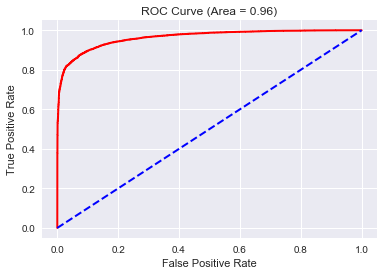

In [46]:
plot_ROC(lr, X_test_onehot)

In order to compare the profitability of my model and the profitability the bank actually made (for the test set), I assume:
- If the loan is granted and the it doesn't get repaid, we lose 1
- If the loan is granted and the it does get repaid, we gain 1
- We gain 0 if the loan is not granted

In [47]:
# bank
score_bank = sum(Y_test == 1) - sum(Y_test == 0)

# my Logistic regression model
tn, fp, fn, tp = confusion_matrix(Y_test, lr.predict(X_test_onehot)).ravel()
score_lr = tp - fp

print("The bank scores {} points".format(score_bank))
print("The Logistic regression model scores {} points".format(score_lr))

The bank scores 4275 points
The Logistic regression model scores 7834 points


We can see that it is a great improvement. But of course, this is not a fair comparison because I am using existing data of borrowers to train my model while the bank didn't have these data (or had much less data) to begin with.

How about the people who were not granted loans? We can use my model to predict what would happen.

In [48]:
# Calculate the fraction of people who would have been granted 
# loans based on my model among those customers who were not 
# granted loans

Y_declined_pred = lr.predict(X_declined_onehot)
Y_declined_pred.sum() / len(Y_declined_pred)

0.3481457920143696

Based on the model, about 35% of the people who didn't get loans would actually repay and should be granted. If we assume the ratio of true positive over false positive that I got for the test set, we can estimate the profitability we would get if we grant loans to those 35%.

In [49]:
tp_pred = int(round(Y_declined_pred.sum()*tp/(tp + fp)))
fp_pred = int(round(Y_declined_pred.sum()*fp/(tp + fp)))
print("Predicted true positive:", tp_pred)
print("Predicted false positive:", fp_pred)
print("The estimated profitability: {} points".format(tp_pred - fp_pred))

Predicted true positive: 17229
Predicted false positive: 1378
The estimated profitability: 15851 points


**Notice that these estimatations are all based on a default threshold of 0.5 of the classifier. If we tune the threshold, the values of true positives/negatives and false positives/negatives would change.**

Now let's try to interpret what the model learns. Specifically, we want to know the relative importnace of each feature, which can be quantified by the coefficients (weights) of the logistic regression model.

In [50]:
# Sort the weights and their corresponding features by their absolute values
temp = sorted(zip(np.round(lr.coef_.reshape(-1), 3), X_onehot.columns.values), key=lambda x: -abs(x[0]))
weight = [x for x, _ in temp]
feature = [x for _, x in temp]

pd.DataFrame({'weight': weight}, index=feature)

,weight
savings,2.794
yearly_salary,1.100
credit_limit,1.032
repaying_Yes,-0.502
limit_used,-0.416
repaying_No,0.348
loan_purpose_business,0.295
loan_purpose_investment,0.248
dependent_number,-0.231
loan_purpose_home,0.187


This shows that the most important features are ``savings``, ``yearly_salary``, ``credit_limit`` ...etc.

One very important thing for a loan granting problem is to interpret individual results. Especially, for the customers we reject, we should provide the reasons why they are not granted loans. We can check the contributions from each features and find out the dominant ones that make the prediction to be 0 (won't repay). Here I use the first three instances of the test set as the examples.

In [51]:
# the predictions for these three instances are 0, 1, 0
lr.predict(X_test_onehot)[:3]

array([0., 1., 0.])

To check the contributions from each features, we can multiply the feature values by the corresponding weights of decision function.

In [52]:
# For a particular customer, sort the multiplication of the weights and the 
# corresponding feature values by the absolute values
def Sort_Contributions(index):
       
    instance = np.round(X_test_onehot.loc[index,:]*lr.coef_.reshape(-1), 3)    
    temp = sorted(zip(instance.values, instance.index), key=lambda x: -abs(x[0]))
    contribution = [x for x, _ in temp]
    feature = [x for _, x in temp]
    
    return pd.DataFrame({'contribution': contribution}, index=feature)

In [53]:
# instance 0: feature values
# negative/positive values mean below/above average
X_test_onehot.loc[0, :]

credit_limit                   -1.024036
limit_used                      1.817212
yearly_salary                  -1.795773
dependent_number               -0.290484
savings                        -0.715252
loan_purpose_business           1.857890
loan_purpose_emergency_funds   -0.440803
loan_purpose_home              -0.567830
loan_purpose_investment        -0.534955
previous_repaid_No             -0.215091
previous_repaid_Yes            -0.840952
repaying_No                    -0.689246
repaying_Yes                   -0.397426
Name: 0, dtype: float64

In [54]:
# instance 0: feature values times the weights
Sort_Contributions(0)

,contribution
savings,-1.999
yearly_salary,-1.976
credit_limit,-1.057
limit_used,-0.756
loan_purpose_business,0.549
repaying_No,-0.240
repaying_Yes,0.200
loan_purpose_investment,-0.133
loan_purpose_home,-0.106
dependent_number,0.067


We see that low ``savings``, low ``yearly_salary``, low ``credit_limit`` and high ``limit_used`` are the most dominant factors that result in the rejection. In the following, I calculate the predicted probability that this customer will repay (instead of 0 or 1)

In [55]:
print("Prediction (probability):", round(lr.predict_proba(X_test_onehot)[0, 1], 3))

Prediction (probability): 0.031


Let's do the same exercise for the second instance

In [56]:
# instance 1: feature values
# negative/positive values mean below/above average
X_test_onehot.loc[1, :]

credit_limit                   -0.516832
limit_used                     -1.377685
yearly_salary                   0.810202
dependent_number               -0.672976
savings                         0.339149
loan_purpose_business           1.857890
loan_purpose_emergency_funds   -0.440803
loan_purpose_home              -0.567830
loan_purpose_investment        -0.534955
previous_repaid_No             -0.215091
previous_repaid_Yes             1.189128
repaying_No                    -0.689246
repaying_Yes                    2.516189
Name: 1, dtype: float64

In [57]:
# instance 1: feature values times the weights
Sort_Contributions(1)

,contribution
repaying_Yes,-1.264
savings,0.948
yearly_salary,0.892
limit_used,0.573
loan_purpose_business,0.549
credit_limit,-0.533
repaying_No,-0.240
dependent_number,0.156
loan_purpose_investment,-0.133
loan_purpose_home,-0.106


We see that high ``savings`` and ``yearly_salary``, and low ``limit_used`` are the most dominant factors that result in the approval. We again calculate the predicted probability that this customer will repay below.

In [58]:
print("Prediction (probability):", round(lr.predict_proba(X_test_onehot)[1, 1], 3))

Prediction (probability): 0.945


Let's do the same exercise for the third instance

In [59]:
# instance 2: feature values
# negative/positive values mean below/above average
X_test_onehot.loc[2, :]

credit_limit                   -0.263230
limit_used                      1.867132
yearly_salary                  -1.795773
dependent_number               -1.055468
savings                        -0.709365
loan_purpose_business          -0.538245
loan_purpose_emergency_funds    2.268588
loan_purpose_home              -0.567830
loan_purpose_investment        -0.534955
previous_repaid_No             -0.215091
previous_repaid_Yes            -0.840952
repaying_No                    -0.689246
repaying_Yes                   -0.397426
Name: 2, dtype: float64

In [60]:
# instance 2: feature values times the weights
Sort_Contributions(2)

,contribution
savings,-1.982
yearly_salary,-1.976
limit_used,-0.777
credit_limit,-0.272
dependent_number,0.244
repaying_No,-0.240
loan_purpose_emergency_funds,-0.229
repaying_Yes,0.200
loan_purpose_business,-0.159
loan_purpose_investment,-0.133


We again see that low ``savings``, low ``yearly_salary``, high ``limit_used``  are the most dominant factors that result in the rejection.

In [61]:
print("Prediction (probability):", round(lr.predict_proba(X_test_onehot)[2, 1], 3))

Prediction (probability): 0.03


## Random Forest Classifier

Now I will try Random Forest classifier, a non-linear model. Let's see if it performs better than the Logistic regression (which in this case simply makes a linear decision boundary to separate the positive and negative examples).

In [62]:
rf = RandomForestClassifier(n_estimators=50, random_state=0)

# Specify parameters and distributions to sample from
parameters = {
    "max_features": [2, 3, 4, 5],
    "min_samples_split": [2, 3, 4, 5],
    "max_depth": range(8, 13)
}

# Run Grid Search
grid_search = GridSearchCV(estimator=rf,
                           param_grid=parameters,
                           scoring='roc_auc',
                           n_jobs=-1)

grid_search = grid_search.fit(X_train_label, Y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)
rf = grid_search.best_estimator_

0.965488809245739
{'max_depth': 10, 'max_features': 2, 'min_samples_split': 2}


In [63]:
evaluation(rf, X_train_label, X_test_label)

--- ROC AUC ---
Training Set: 0.978961241585238
Test Set: 0.9645963674230713

--- Accuracy ---
Training Set: 0.9223251491441077
Test Set: 0.9010281877316919

--- Confusion Matrix ---
True Positive: 8471
False Negative: 815
True Negative: 4411
False Positive: 600

--- Precision ---
Training Set: 0.9509940119760479
Test Set: 0.9338551427626502

--- Recall ---
Training Set: 0.9267973856209151
Test Set: 0.9122334697393927

--- F1 Score ---
Training Set: 0.9387398037593095
Test Set: 0.9229176880753936


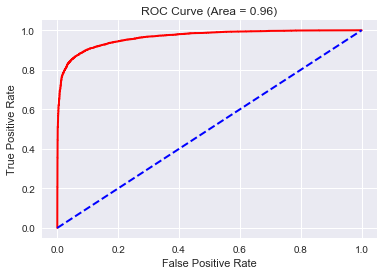

In [64]:
plot_ROC(rf, X_test_label)

The performance of this model is basically consistent with the Logistic regression. Therefore, the logistic regression is a better choice if we consider computation time.

In [65]:
# bank
score_bank = sum(Y_test == 1) - sum(Y_test == 0)

# my Logistic regression model
tn, fp, fn, tp = confusion_matrix(Y_test, rf.predict(X_test_label)).ravel()
score_rf = tp - fp

print("The bank scores {} points".format(score_bank))
print("The Random Forest classifier scores {} points".format(score_rf))

The bank scores 4275 points
The Random Forest classifier scores 7871 points


The score of 7871 points is only a little higher than the score of the Logistic regression (7834 points)

How about the people who were not granted loans?

In [66]:
# Calculate the fraction of people who would have been granted 
# loans based on my model among those customers who were not 
# granted loans

Y_declined_pred = rf.predict(X_declined_label)
Y_declined_pred.sum()/len(Y_declined_pred)

0.3496800508924896

Again, about 35% of the people who didn't get loans would actually repay based on the model. Assuming the ratio of true positive over false positive I got above, we can estimate the profitability we would get if these 35% are granted loans.

In [67]:
tp_pred = int(round(Y_declined_pred.sum()*tp/(tp + fp)))
fp_pred = int(round(Y_declined_pred.sum()*fp/(tp + fp)))
print("Predicted true positive:", tp_pred)
print("Predicted false positive:", fp_pred)
print("The estimated profitability: {} points".format(tp_pred - fp_pred))

Predicted true positive: 17453
Predicted false positive: 1236
The estimated profitability: 16217 points


Again, notice that these estimatations are all based on a default threshold of 0.5 of the classifier. If we tune the threshold, the values of true positives/negatives and false positives/negatives would change.

We can inspect the relative importnace of each feature using the ``feature_importances_`` attribute of the model.

In [68]:
imp = pd.DataFrame(rf.feature_importances_, columns=['Importance'], index=X_label.columns)
imp = imp.sort_values(['Importance'], ascending=False)
imp

,Importance
savings,0.576377
yearly_salary,0.164365
credit_limit,0.128203
repaying,0.069223
limit_used,0.033087
dependent_number,0.012779
loan_purpose,0.009690
previous_repaid,0.006277


We can see that the order of feature importance is very similar to the one determined by the logistic regression, and the main difference is just due to one-hot v.s. label encoding. 

To interpret individual results from a decision tree or random forest, we can use the [treeinterpreter](https://github.com/andosa/treeinterpreter) (also see [this](http://blog.datadive.net/interpreting-random-forests/) and [this](http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/) blog posts). Again, I will use the first three instances of the test set as the examples.

In [69]:
instances = X_test_label.iloc[:3, :]

# see the links above for "treeinterpreter" 
prediction, bias, contribution = ti.predict(rf, instances)

for i in range(len(instances)):
    print("Instance", i)
    print("Prediction:", round(prediction[i, 1], 3))
    print("Bias (training set mean value):", round(bias[i, 1], 3))
    print("Feature contributions:")
    
    # The feature contributions are sorted by their absolute impact
    for c,feature in sorted(zip(contribution[i, :, 1], X_label.columns.values), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 3))
    print("-" * 40)

Instance 0
Prediction: 0.05
Bias (training set mean value): 0.642
Feature contributions:
savings -0.294
yearly_salary -0.143
credit_limit -0.134
limit_used -0.055
loan_purpose 0.024
repaying 0.024
previous_repaid -0.01
dependent_number -0.003
----------------------------------------
Instance 1
Prediction: 0.909
Bias (training set mean value): 0.642
Feature contributions:
savings 0.357
repaying -0.192
yearly_salary 0.096
credit_limit -0.058
limit_used 0.039
loan_purpose 0.019
dependent_number 0.005
previous_repaid 0.0
----------------------------------------
Instance 2
Prediction: 0.07
Bias (training set mean value): 0.642
Feature contributions:
savings -0.324
yearly_salary -0.192
limit_used -0.053
credit_limit -0.04
dependent_number 0.038
repaying 0.023
previous_repaid -0.012
loan_purpose -0.012
----------------------------------------


- instance 0: ``savings``, ``yearly_salary``, ``credit_limit`` and ``limit_used`` are the most dominant factors that result in the rejection.
- instance 1: ``savings`` and ``yearly_salary`` are the most dominant factors that result in the approval.
- instance 2: similar to instance 0